In [147]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from matplotlib.legend_handler import HandlerLine2D
import math

# set k so that the resulting graph density is as close as possible to the desired density
def get_k(n, density):
  max_links = n*(n-1)/2
  links = max_links * density
  k = 2*links / n
  k_lower = int(k - k%2)
  k_upper = k_lower + 2
  if k_lower > 0 and abs((n*k_lower/2) - links) < abs((n*k_upper/2) - links):
    return k_lower
  else:
    return k_upper

def plot_network(G):
  pos = nx.circular_layout(G)
  plt.figure(figsize = (12, 12))
  nx.draw_networkx(G, pos)
  plt.show()

# Initialize a simulation with certain parameters and return a communication link matrix and agent list
def init_sim(n, fixed_trust=True):
  # Create small-world network
  k = get_k(n, density=0.05) # density or k not given in the paper
  G = nx.connected_watts_strogatz_graph(n=n, k=k, p=0.5, tries=100) # p not given in the paper
  # print(f"n = {n}, density = {nx.density(G)}, k = {k}, n_edges = {G.number_of_edges()}")
  # plot(network(G))

  G = nx.to_numpy_array(G) # Matrix of undirected edges
  A = [dict() for _ in range(G.shape[0])] # List of agents with their parameters
  for i,d in enumerate(A):
    d['p_belief'] = 0.5 # an inquirer’s (initial) degree of belief in p (P(H) in the paper)
    d['p_belief_shadow'] = d['p_belief'] # belief for the shadow agent, which should not be influenced by communication
    if fixed_trust:
      d['inquiry_trust'] = 0.66 # the inquirer’s degree of trust in her own inquiries
      d['inquiry_trust_shadow'] = 0.66
      d['listen_trust'] = [0.66 for x in G[i] if x==1] # the recipient's trust in the sender
    else:
      d['inquiry_trust'] = np.random.beta(2, 1)
      d['inquiry_trust_shadow'] = np.random.beta(2, 1)
      d['listen_trust'] = [np.random.beta(2, 1) for x in G[i] if x==1]
    d['listen_trust'] = np.array(d['listen_trust'])
  return G, A

def update_belief_trust_single(belief, trust, inquiry, fixed_trust=True):
  t, c = trust, belief
  t_bar, c_bar = 1 - t, 1- c
  if not inquiry: t, t_bar, c, c_bar = t_bar, t, c_bar, c
  belief = (belief * t) / (belief * t + (1 - belief) * t_bar)
  # trust update is not implemented (only fixed_trust works, which has the same results as update agents in the paper)
  return belief, trust

def update_belief_trust_multiple(belief, trust, inquiries, fixed_trust=True):
  pos = [x for i,x in enumerate(trust) if inquiries[i]]
  pos_prod = math.prod(pos)
  pos_prod_bar = math.prod([1-x for x in pos])
  neg = [x for i,x in enumerate(trust) if not inquiries[i]]
  neg_prod = math.prod(neg)
  neg_prod_bar = math.prod([1-x for x in neg])
  belief = (belief * pos_prod * neg_prod_bar) / (belief * pos_prod * neg_prod_bar + (1 - belief) * pos_prod_bar * neg_prod)
  # trust update is not implemented
  return belief, trust

def get_votes(A):
  votes_for, votes_for_shadow = 0, 0
  for a in A:
    if a['p_belief'] > 0.5: votes_for += 1
    elif a['p_belief'] == 0.5: votes_for += 0.5 # vote is split
    if a['p_belief_shadow'] > 0.5: votes_for_shadow += 1
    elif a['p_belief_shadow'] == 0.5: votes_for_shadow += 0.5
  return votes_for, votes_for_shadow

def get_messages(G, A, i, listen_chance):
  senders, inquiries = [], []
  a2 = -1 # idx of other agent in A[i]['listen_trust']
  for j, link in enumerate(G[i]):
    if link==1:
      a2 += 1
      if assertion_threshold > 0.5 and abs(0.5-A[j]['p_belief']) >= assertion_threshold-0.5:
        # truth
        inquiry = A[j]['p_belief'] > 0.5
      elif assertion_threshold < 0.5 and abs(0.5-A[j]['p_belief']) <= assertion_threshold-0.5:
        # lie
        inquiry = A[j]['p_belief'] < 0.5
      elif assertion_threshold == 0.5:
        # random
        inquiry = np.random.rand() < 0.5
      else: continue

      if np.random.rand() < listen_chance:
        senders.append(a2)
        inquiries.append(inquiry)
  return senders, inquiries

def run_sim(n, p, assertion_threshold, inquiry_acc, inquiry_chance, listen_chance, fixed_trust=True):
  G, A = init_sim(n, fixed_trust=fixed_trust)

  for epoch in range(50):
    agents = np.array(range(len(A)))
    np.random.shuffle(agents)
    for i in agents:
      senders, inquiries = get_messages(G, A, i, listen_chance)

      # potentially inquire from outside the network
      if np.random.rand() < inquiry_chance:
        inquiry = np.random.rand() < inquiry_acc
        if not p: inquiry = not inquiry
        A[i]['p_belief_shadow'], A[i]['inquiry_trust_shadow'] = update_belief_trust_single(A[i]['p_belief_shadow'], A[i]['inquiry_trust_shadow'], inquiry, fixed_trust=fixed_trust)
        senders.append(-1) # self
        inquiries.append(inquiry)

      # update belief and trusts
      if senders != []:
        if -1 in senders:
          trusts = list(A[i]['listen_trust'][senders[:-1]]) + [A[i]['inquiry_trust']]
        else:
          trusts = A[i]['listen_trust'][senders]

        A[i]['p_belief'], new_trusts = update_belief_trust_multiple(A[i]['p_belief'], trusts, inquiries, fixed_trust=fixed_trust)

        if -1 in senders:
          A[i]['listen_trust'][senders[:-1]], A[i]['inquiry_trust'] = new_trusts[:-1], new_trusts[-1]
        else:
          A[i]['listen_trust'][senders] = new_trusts

  return get_votes(A)

# https://stackoverflow.com/questions/19125722/adding-a-matplotlib-legend
def formatFloat(fmt, val):
  ret = fmt % val
  if ret.startswith("0."):
    return ret[1:]
  if ret.startswith("-0."):
    return "-" + ret[2:]
  return ret

def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_ls("-")
    handle.set_marker(".")

# plot the percentage of correct majority votes for each number of agents
def plot_sim_avg(perc, perc_majority, ns, inquiry_accs, inquiry_chance, listen_chance):
  for i in range(len(perc)):
    color = ['grey', 'lime', 'blue'][i]
    label = "p="+formatFloat("%.2f", inquiry_accs[i])
    if i==0: label += f" (act="+formatFloat("%.2f", inquiry_chance)+" & com="+formatFloat("%.2f", listen_chance)+")"
    plt.plot(perc[i], color=color, ls='--', label=label)
    plt.plot(perc_majority[i], color=color)
    plt.fill_between(list(range(len(ns))), perc[i], perc_majority[i], color=color, alpha=0.2)
  plt.xticks(np.linspace(0, len(ns), num=6), labels=np.linspace(0, 100, num=6, dtype=int))
  plt.yticks(rotation=90)
  plt.xlabel("Net Size")
  plt.ylabel("Percentage Correct Vote")
  plt.ylim(0, 100)
  plt.legend(loc='lower right', frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})


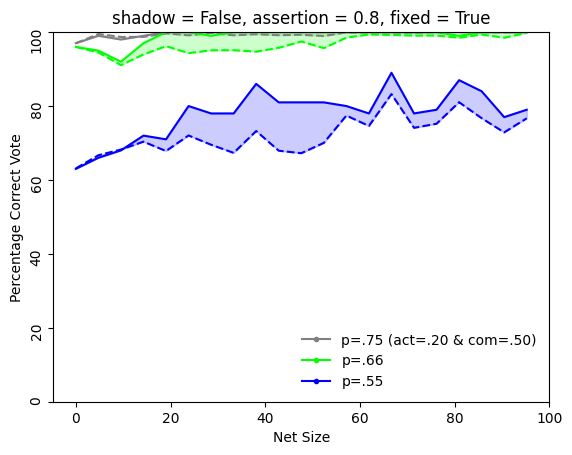

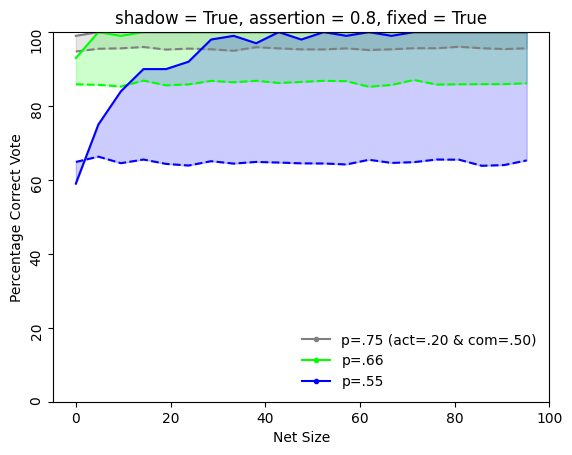

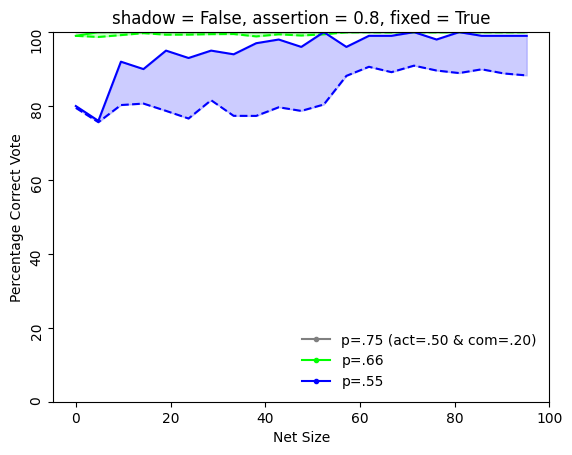

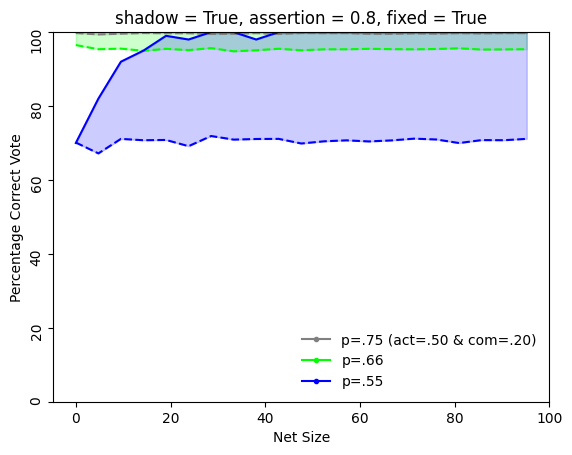

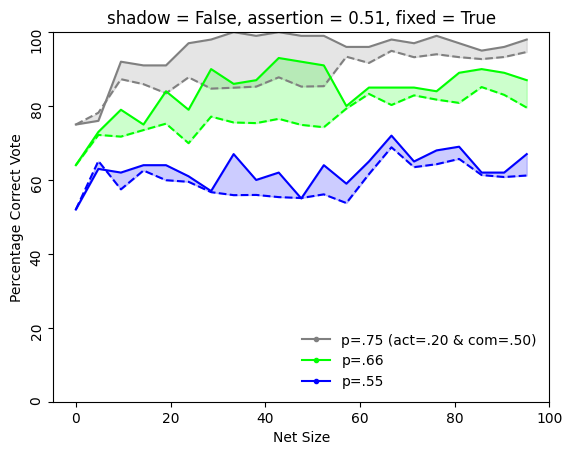

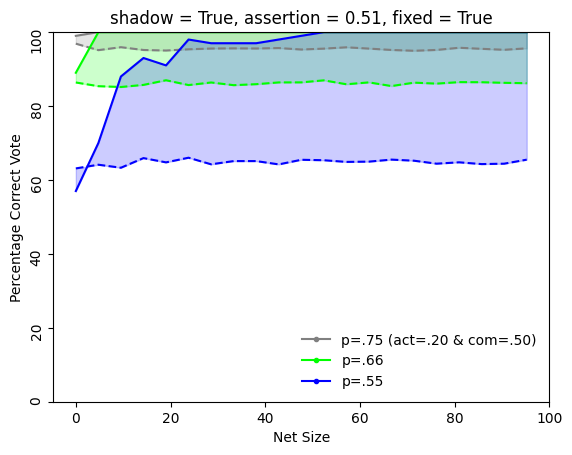

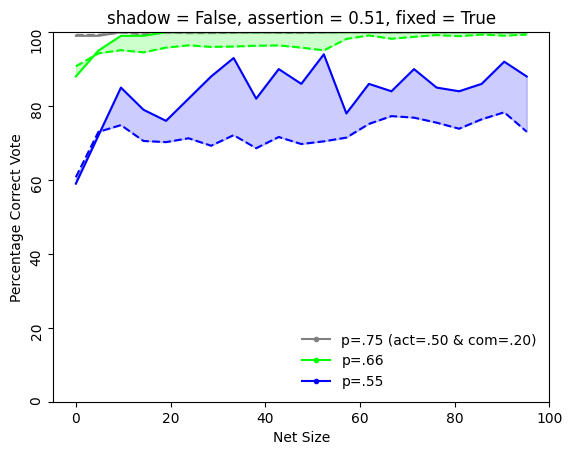

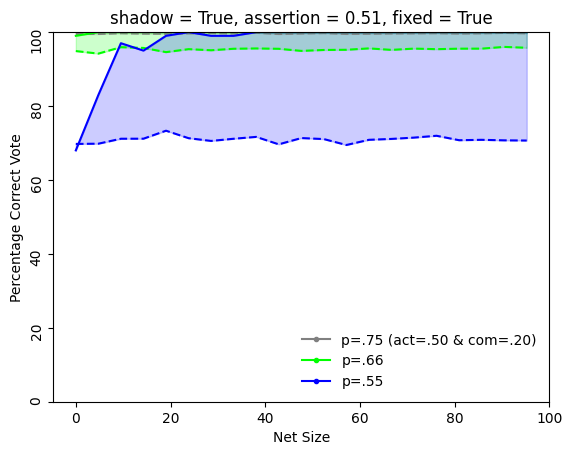

In [151]:
ns = np.linspace(4, 100, num=21, dtype=int)
inquiry_accs = [0.75, 0.66, 0.55]
runs = 100
for assertion_threshold in [0.8, 0.51]: # the degree of confidence in a proposition (“p” or “not-p”) required for the sender to submit a corresponding message to the recipient(s).
  for fixed_trust in [True]: # 'update agents' vs 'fixed trust agents' in the paper
    for inquiry_chance in [0.2, 0.5]: # the probability that the inquirer will conduct an inquiry ('act' in the paper)
      listen_chance = [x for x in [0.5, 0.2] if x != inquiry_chance][0] # the probability that the recipient will listen to a message she receives (= chance to send for the other agent, 'com' in the paper)
      perc, perc_shadow, perc_majority, perc_majority_shadow = [], [], [], []
      for inquiry_acc in inquiry_accs: # the reliability of the inquirer’s own inquiries ('p' in the paper)
        perc.append([]); perc_shadow.append([]); perc_majority.append([]); perc_majority_shadow.append([])
        for n in ns: # number of agents
          n_correct, n_correct_shadow, n_majority_correct, n_majority_correct_shadow = 0, 0, 0, 0

          for run in range(runs): # take average over 100 simulations for each set of parameters
            p = bool(run < runs*1.6) # p is true in 60% of the simulations
            votes_for, votes_for_shadow = run_sim(n, p, assertion_threshold, inquiry_acc, inquiry_chance=inquiry_chance, listen_chance=listen_chance, fixed_trust=fixed_trust)
            if p:
              n_correct += votes_for/n; n_correct_shadow += votes_for_shadow/n
            else:
              n_correct += 1 - (votes_for/n); n_correct_shadow += 1 - (votes_for_shadow/n)
            if (votes_for > n/2 and p) or (votes_for < n/2 and not p): n_majority_correct += 1
            if (votes_for_shadow > n/2 and p) or (votes_for_shadow < n/2 and not p): n_majority_correct_shadow += 1

          perc[-1].append(n_correct/runs*100); perc_shadow[-1].append(n_correct_shadow/runs*100); perc_majority[-1].append(n_majority_correct/runs*100); perc_majority_shadow[-1].append(n_majority_correct_shadow/runs*100)
      plt.figure()
      plot_sim_avg(perc, perc_majority, ns, inquiry_accs, inquiry_chance, listen_chance)
      plt.title(f"shadow = False, assertion = {assertion_threshold}, fixed = {fixed_trust}")
      plt.figure()
      plot_sim_avg(perc_shadow, perc_majority_shadow, ns, inquiry_accs, inquiry_chance, listen_chance)
      plt.title(f"shadow = True, assertion = {assertion_threshold}, fixed = {fixed_trust}")
      plt.show()